1\. **Radioactive decay chain**

${\rm Tl}^{208}$ decays to ${\rm Pb}^{208}$ with a half-lieve of 3.052 minutes. Suppose to start with a sample of 1000 Thallium atoms and 0 of Lead atoms.

* Take steps in time of 1 second and at each time-step decide whether each Tl atom has decayed or not, accordingly to the probability $p(t)=1-2^{-t/\tau}$. Subtract the total number of Tl atoms that decayed at each step from the Tl sample and add them to the Lead one. Plot the evolution of the two sets as a function of time  
* Repeat the exercise by means of the inverse transform method: draw 1000 random numbers from the non-uniform probability distribution $p(t)=2^{-t/\tau}\frac{\ln 2}{\tau}$ to represent the times of decay of the 1000 Tl atoms. Make a plot showing the number of atoms that have not decayed as a function of time

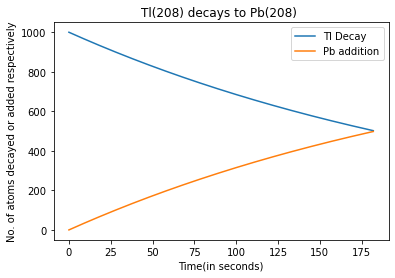

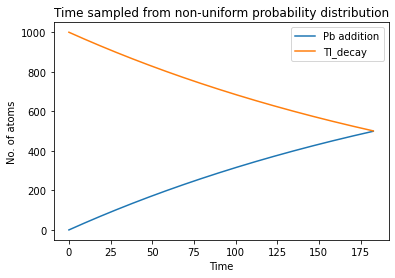

In [8]:
import numpy as np
import matplotlib.pyplot as plt

tau = 3.052*60 #half-life
N_Tl = 1000 #number of samples of thallium
N_Pb = 0 #number of samples of lead

def p(t,tau=3.052*60):
    return 1-2**(-t/tau)

Tl_decay = []

for i in range(int(tau)):
    Tl_decay.append(p(i))
    
Tl_decay_1000 = N_Tl - np.array(Tl_decay)*N_Tl #decay of Thallium from 1000 atoms.
Pb_add = np.array(Tl_decay)*1000

time = np.arange(int(tau))
plt.plot(time,Tl_decay_1000,label='Tl Decay')
plt.plot(time,Pb_add,label='Pb addition')
plt.title("Tl(208) decays to Pb(208) ")
plt.xlabel("Time(in seconds)")
plt.ylabel("No. of atoms decayed or added respectively")
plt.legend(loc='best')
plt.show()

def nonuniform_pdf(t,tau=3.052*60):
    return 2**(-t/tau)*np.log(2)/tau

time = np.linspace(0,int(tau),10000)
nonuniform_prob = nonuniform_pdf(time)

indices = list(range(0,10000))

time_with_nonuniform_pdf = np.random.choice(time, size=1000, replace=False, p=(nonuniform_prob)/sum(nonuniform_prob))#p=[probabilities]
time_with_nonuniform_pdf = np.sort(time_with_nonuniform_pdf)

plt.plot(time_with_nonuniform_pdf,p(time_with_nonuniform_pdf)*1000,label='Pb addition')
plt.plot(time_with_nonuniform_pdf,1000-p(time_with_nonuniform_pdf)*1000,label='Tl_decay')
plt.legend()
plt.title("Time sampled from non-uniform probability distribution")
plt.xlabel("Time")
plt.ylabel('No. of atoms')
plt.show()

2\. **Rutherford Scattering**

The scattering angle $\theta$ of $\alpha$ particles hitting a positively charged nucleus of a Gold atom ($Z=79$) follows the rule:

$$
\tan{\frac{1}{2} \theta} = \frac{Z e^2} {2\pi \epsilon_0 E b}
$$

where $E=7.7$ MeV and $b$ beam is the impact parameter. The beam is represented by a 2D gaussian distribution with $\sigma=a_0/100$ for both coordinates ($a_0$ being the Bohr radius). Assume 1 million $\alpha$ particles are shot on the gold atom.

Computing the fraction of particles that "bounce back",i.e. those particle whose scattering angle is greater than $\pi/2$ (which set a condition on the impact parameter $b$)

In [3]:
Z = 79
e = 1.6e-19
epsilon0 = 8.854e-12
E = (7.7e6)*(1.6e-19) #energy
a0 = 1e-15 #Bohr radius
N = int(1e6) #number of particles
sigma = a0/100
b = np.random.normal(scale=sigma,size=N)
theta = 2*np.arctan((Z*e**2)/(2*np.pi*epsilon0*E*b))
bounce_back = len(theta[theta>abs(np.pi/2)])
fraction_bounce_back = bounce_back/N

print('number of particles that bounce back for a given sigma:', fraction_bounce_back)


No. of particles that bounce back for given sigma=10^-17:  0.5002


3\. **Monte Carlo integration: hit/miss vs mean value method**

Consider the function 

$$f(x) =\sin^2{\frac{1}{x(2-x)}}$$

* Compute the integral of $f(x)$ between 0 and 2 with the hit/miss method. Evaluate the error of your estimate
* Repeat the integral with the mean value method. Evaluate the error and compare it with the previous one

integral of hit/miss method 0.72467
integral of mean values method 0.7263487732658344


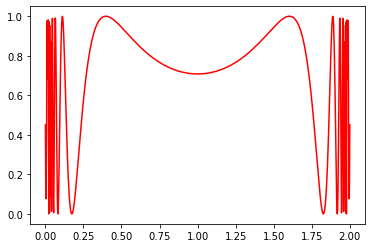

In [9]:
#hit/miss method
def f(x):
    return (np.sin(1/(x*(2-x))))**2

x=np.linspace(0.001,1.999,1000) #it appears to be singular points at x=0 and x=2 
plt.plot(x,f(x),'r-')

N=100000
count=0
for i in range(N):
    x=np.random.random()
    y=np.random.random()
    if y<f(x): count+=1
I=count/N
print('integral of hit/miss method',I)

#mean value method
def f(x):
    return (np.sin(1/(x*(2-x))))**2

N=100000
x = np.random.uniform(size=N)
a = 0
b = 1
I = ((b-a)/N)*sum(f(x))
print('integral of mean values method',I)


4\. **Monte Carlo integration in high dimension**

* Start of by computing the area of a circle of unit radius, by integrating the function 

$$
f(x,y)=
\left\{
\begin{array}{ll}
      1 & x^2+y^2\le 1 \\
      0 & {\rm elsewhere}
\end{array} 
\right.
$$

* Generalize the result for a 10D sphere



In [10]:
N = 1000000
r=1 #radius
x = np.random.uniform(-1.0,1.0,size=N)
y = np.random.uniform(-1.0,1.0,size=N)
distance = x**2+y**2
inside = len(distance[np.sqrt(distance)<=r])
area = 4*(inside/N)

print('area of the circle',area)

#generalisation 10d
def nSphereVolume(dim, N):
    point = np.random.uniform(-1.0, 1.0, size=[N,dim])
    distance = np.apply_along_axis(np.linalg.norm, 1, point)
    inside = len(distance[distance<=1])
    return np.power(2.0, dim) * (inside / N)

print('volume of 10d sphere',nSphereVolume(10, 100000))
print('area of circle', nSphereVolume(2,100000))

area of the circle 3.142912
volume of 10d sphere 2.31424
area of circle 3.14044


5\. **Monte Carlo integration with importance sampling** 

Calculate the value of the integral:

$$
I=\int_0^1 \frac{x^{-1/2}}{e^x+1} dx
$$

using the importance sampling method with $w(x)=1/\sqrt{x}$. You should get a result about 0.84

In [11]:
def f(x):
    return x**-0.5/(np.exp(x)+1)

def g(x):
    return np.sqrt(x)**-1

#inverse transform method for sampling
def h(x): 
    return np.square(x)/4

n = int(1e6)
x = np.random.uniform(0,2,size=n)
w = h(x)
I = (np.sum(f(w)/g(w))*2)/n

print(np.round((I),2))

0.84
